# CH-04 讓 AI 計算技術指標及資料視覺化

## 4-1 技術指標公式太複雜？讓 AI 自動化計算

### 1️⃣ 安裝及匯入套件

In [1]:
!pip install openai
!pip install yfinance==0.2.38
from  openai import OpenAI, OpenAIError # 串接 OpenAI API
import yfinance as yf
import pandas as pd # 資料處理套件
import datetime as dt # 時間套件

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.0/73.0 kB 1.7 MB/s eta 0:00:00
  Attempting uninstall: yfinance
    Found existing installation: yfinance 0.2.49
    Uninstalling yfinance-0.2.49:
      Successfully uninstalled yfinance-0.2.49


### 2️⃣ 取得股票資料

In [2]:
# 輸入股票代號
stock_id = "2330.tw"
# 抓取半年資料
end = dt.date.today() # 資料結束時間
start = end - dt.timedelta(days=180) # 資料開始時間
df = yf.download(stock_id, start=start, end=end).reset_index()

print(df)

[*********************100%%**********************]  1 of 1 completed

          Date    Open    High     Low   Close    Adj Close    Volume
0   2024-06-07   885.0   888.0   879.0   879.0   871.728271  41075399
1   2024-06-11   892.0   895.0   883.0   883.0   875.695190  48228488
2   2024-06-12   888.0   914.0   888.0   909.0   901.480103  48106925
3   2024-06-13   923.0   935.0   911.0   919.0   914.919983  55857091
4   2024-06-14   916.0   922.0   905.0   922.0   917.906616  38408123
..         ...     ...     ...     ...     ...          ...       ...
115 2024-11-27  1010.0  1020.0  1000.0  1000.0  1000.000000  31276090
116 2024-11-28  1005.0  1005.0   992.0  1005.0  1005.000000  33689956
117 2024-11-29   995.0  1010.0   994.0   996.0   996.000000  40094983
118 2024-12-02  1020.0  1040.0  1015.0  1035.0  1035.000000  31168404
119 2024-12-03  1060.0  1065.0  1055.0  1055.0  1055.000000  43414538

[120 rows x 7 columns]


### 3️⃣ 輸入 OpenAI API KEY

In [7]:
from google.colab import userdata

client = OpenAI(
  base_url="https://api.groq.com/openai/v1",
  api_key=userdata.get('GROQ_API_KEY')
)

### 4️⃣ 創建 GPT 3.5 模型函式

In [8]:
model_name = "llama3-groq-70b-8192-tool-use-preview"

def get_reply(messages):
  try:
    response = client.chat.completions.create(model=model_name,
                         messages=messages)
    reply = response.choices[0].message.content
  except OpenAIError as err:
    reply = f"發生 {err.type} 錯誤\n{err.message}"
  return reply

# 設定 AI 角色, 使其依據使用者需求進行 df 處理
def ai_helper(df, user_msg):

  msg = [{
    "role":
    "system",
    "content":
    f"As a professional code generation robot, \
      I require your assistance in generating Python code \
      based on specific user requirements. To proceed, \
      I will provide you with a dataframe (df) that follows the \
      format {df.columns}. Your task is to carefully analyze the \
      user's requirements and generate the Python code \
      accordingly.Please note that your response should solely \
      consist of the code itself, \
      and no additional information should be included."
  }, {
    "role":
    "user",
    "content":
    f"The user requirement:{user_msg} \n\
       Your task is to develop a Python function named \
      'calculate(df)'. This function should accept a dataframe as \
      its parameter. Ensure that you only utilize the columns \
      present in the dataset, specifically {df.columns}. \
      After processing, the function should return the processed \
      dataframe. Your response should strictly contain the Python \
      code for the 'calculate(df)' function \
      and exclude any unrelated content."
  }]

  reply_data = get_reply(msg)
  cleaned_code = reply_data.replace("```", "")
  cleaned_code = cleaned_code.replace("python", "")

  return cleaned_code

### 讓 AI 自動生成技術指標程式碼

### 5️⃣ 計算移動平均線

In [9]:
code_str = ai_helper(df, "計算8日MA與13日MA ")
print(code_str)
exec(code_str)
new_df = calculate(df)
new_df.tail()

def calculate(df):
    df['8d_MA'] = df['Close'].rolling(window=8).mean()
    df['13d_MA'] = df['Close'].rolling(window=13).mean()
    return df


,Date,Open,High,Low,Close,Adj Close,Volume,8d_MA,13d_MA
115,2024-11-27,1010.0,1020.0,1000.0,1000.0,1000.0,31276090,1022.500,1032.307692
116,2024-11-28,1005.0,1005.0,992.0,1005.0,1005.0,33689956,1020.000,1026.153846
117,2024-11-29,995.0,1010.0,994.0,996.0,996.0,40094983,1014.500,1022.000000
118,2024-12-02,1020.0,1040.0,1015.0,1035.0,1035.0,31168404,1015.750,1022.000000
119,2024-12-03,1060.0,1065.0,1055.0,1055.0,1055.0,43414538,1021.375,1023.538462


### 6️⃣ 計算 MACD

In [10]:
code_str = ai_helper(df, "先計算 EMA 再計算 MACD, 欄位名稱用 MACD_Histogram 命名")
print(code_str)
exec(code_str)
new_df = calculate(df)
new_df.tail()

def calculate(df):
    df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['Signal'] = df['MACD'].ewm(span=9, adjust=False).mean()
    df['MACD_Histogram'] = df['MACD'] - df['Signal']
    return df


,Date,Open,High,Low,Close,Adj Close,Volume,8d_MA,13d_MA,EMA_12,EMA_26,MACD,Signal,MACD_Histogram
115,2024-11-27,1010.0,1020.0,1000.0,1000.0,1000.0,31276090,1022.500,1032.307692,1027.184602,1031.675519,-4.490917,1.997230,-6.488147
116,2024-11-28,1005.0,1005.0,992.0,1005.0,1005.0,33689956,1020.000,1026.153846,1023.771586,1029.699555,-5.927968,0.412190,-6.340159
117,2024-11-29,995.0,1010.0,994.0,996.0,996.0,40094983,1014.500,1022.000000,1019.499035,1027.203291,-7.704257,-1.211099,-6.493158
118,2024-12-02,1020.0,1040.0,1015.0,1035.0,1035.0,31168404,1015.750,1022.000000,1021.883799,1027.780825,-5.897027,-2.148285,-3.748742
119,2024-12-03,1060.0,1065.0,1055.0,1055.0,1055.0,43414538,1021.375,1023.538462,1026.978599,1029.797061,-2.818462,-2.282320,-0.536142


### 7️⃣ 計算 RSI

In [12]:
code_str = ai_helper(df, "計算 RSI ")
print(code_str)
exec(code_str)
new_df = calculate(df)
new_df.tail()

def calculate(df):
    df['RSI'] = 100 - (100 / (1 + df['avg_up'] / df['avg_down']))
    return df


,Date,Open,High,Low,Close,Adj Close,Volume,8d_MA,13d_MA,EMA_12,EMA_26,MACD,Signal,MACD_Histogram,diff,up,down,avg_up,avg_down,RSI
115,2024-11-27,1010.0,1020.0,1000.0,1000.0,1000.0,31276090,1022.500,1032.307692,1027.184602,1031.675519,-4.490917,1.997230,-6.488147,-10.0,0.0,10.0,4.863061,9.339023,34.241883
116,2024-11-28,1005.0,1005.0,992.0,1005.0,1005.0,33689956,1020.000,1026.153846,1023.771586,1029.699555,-5.927968,0.412190,-6.340159,5.0,5.0,0.0,4.881319,8.093820,37.620555
117,2024-11-29,995.0,1010.0,994.0,996.0,996.0,40094983,1014.500,1022.000000,1019.499035,1027.203291,-7.704257,-1.211099,-6.493158,-9.0,0.0,9.0,4.230477,8.214644,33.993056
118,2024-12-02,1020.0,1040.0,1015.0,1035.0,1035.0,31168404,1015.750,1022.000000,1021.883799,1027.780825,-5.897027,-2.148285,-3.748742,39.0,39.0,0.0,8.866413,7.119358,55.464407
119,2024-12-03,1060.0,1065.0,1055.0,1055.0,1055.0,43414538,1021.375,1023.538462,1026.978599,1029.797061,-2.818462,-2.282320,-0.536142,20.0,20.0,0.0,10.350892,6.170110,62.652929


### 8️⃣ 計算布林通道

In [13]:
code_str = ai_helper(df, "請計算1.5個標準差的布林通道, 欄位以 Upper_Band 和 Lower_Band 命名")
print(code_str)
exec(code_str)
new_df = calculate(df)
new_df.tail()

def calculate(df):
    df['Upper_Band'] = df['EMA_26'] + 1.5 * df['EMA_26'].rolling(window=26).std()
    df['Lower_Band'] = df['EMA_26'] - 1.5 * df['EMA_26'].rolling(window=26).std()
    return df


,Date,Open,High,Low,Close,Adj Close,Volume,8d_MA,13d_MA,EMA_12,...,Signal,MACD_Histogram,diff,up,down,avg_up,avg_down,RSI,Upper_Band,Lower_Band
115,2024-11-27,1010.0,1020.0,1000.0,1000.0,1000.0,31276090,1022.500,1032.307692,1027.184602,...,1.997230,-6.488147,-10.0,0.0,10.0,4.863061,9.339023,34.241883,1043.992804,1019.358234
116,2024-11-28,1005.0,1005.0,992.0,1005.0,1005.0,33689956,1020.000,1026.153846,1023.771586,...,0.412190,-6.340159,5.0,5.0,0.0,4.881319,8.093820,37.620555,1040.599835,1018.799275
117,2024-11-29,995.0,1010.0,994.0,996.0,996.0,40094983,1014.500,1022.000000,1019.499035,...,-1.211099,-6.493158,-9.0,0.0,9.0,4.230477,8.214644,33.993056,1037.089336,1017.317247
118,2024-12-02,1020.0,1040.0,1015.0,1035.0,1035.0,31168404,1015.750,1022.000000,1021.883799,...,-2.148285,-3.748742,39.0,39.0,0.0,8.866413,7.119358,55.464407,1036.951829,1018.609822
119,2024-12-03,1060.0,1065.0,1055.0,1055.0,1055.0,43414538,1021.375,1023.538462,1026.978599,...,-2.282320,-0.536142,20.0,20.0,0.0,10.350892,6.170110,62.652929,1038.492590,1021.101531


### 9️⃣ 能量潮指標 (On-Balance Volumem, OBV)

In [15]:
import numpy as np
code_str = ai_helper(df, "計算 OBV 指標")
print(code_str)
exec(code_str)
new_df = calculate(df)
new_df.tail()

def calculate(df):
    df['OBV'] = np.where(df['Close'] > df['Close'].shift(1), df['Volume'], np.where(df['Close'] < df['Close'].shift(1), -df['Volume'], 0))
    df['OBV_SMA'] = df['OBV'].rolling(window=20).mean()
    df['OBV_EMA'] = df['OBV'].ewm(span=20, adjust=False).mean()
    return df


,Date,Open,High,Low,Close,Adj Close,Volume,8d_MA,13d_MA,EMA_12,...,up,down,avg_up,avg_down,RSI,Upper_Band,Lower_Band,OBV,OBV_SMA,OBV_EMA
115,2024-11-27,1010.0,1020.0,1000.0,1000.0,1000.0,31276090,1022.500,1032.307692,1027.184602,...,0.0,10.0,4.863061,9.339023,34.241883,1043.992804,1019.358234,-31276090,-7863181.85,-1.198285e+07
116,2024-11-28,1005.0,1005.0,992.0,1005.0,1005.0,33689956,1020.000,1026.153846,1023.771586,...,5.0,0.0,4.881319,8.093820,37.620555,1040.599835,1018.799275,33689956,-4268584.85,-7.633061e+06
117,2024-11-29,995.0,1010.0,994.0,996.0,996.0,40094983,1014.500,1022.000000,1019.499035,...,0.0,9.0,4.230477,8.214644,33.993056,1037.089336,1017.317247,-40094983,-3549321.25,-1.072467e+07
118,2024-12-02,1020.0,1040.0,1015.0,1035.0,1035.0,31168404,1015.750,1022.000000,1021.883799,...,39.0,0.0,8.866413,7.119358,55.464407,1036.951829,1018.609822,31168404,-3328299.95,-6.734855e+06
119,2024-12-03,1060.0,1065.0,1055.0,1055.0,1055.0,43414538,1021.375,1023.538462,1026.978599,...,20.0,0.0,10.350892,6.170110,62.652929,1038.492590,1021.101531,43414538,-2776854.15,-1.958723e+06


### 讓 AI 自動統整 Dataframe

### 🔟 將日頻資料轉換成月頻資料

In [16]:
code_str = ai_helper(df, "請將日K線的資料轉換成月K線 ")
print(code_str)
exec(code_str)
new_df = df
df_monthly = new_df
df_monthly = calculate(df_monthly)
df_monthly.tail()

def calculate(df):
    df['Month'] = df['Date'].dt.to_period('M')
    df_grouped = df.groupby('Month').agg({
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume': 'sum'
    }).reset_index()
    df_grouped.columns = ['Month', 'Open', 'High', 'Low', 'Close', 'Volume']
    return df_grouped


,Month,Open,High,Low,Close,Volume
2,2024-08,969.0,977.0,813.0,944.0,991085377
3,2024-09,950.0,1025.0,888.0,957.0,676410210
4,2024-10,967.0,1100.0,967.0,1030.0,792908603
5,2024-11,996.0,1090.0,992.0,996.0,762456855
6,2024-12,1020.0,1065.0,1015.0,1055.0,74582942


## 4-2 資料視覺化

### 1️⃣1️⃣ 安裝及匯入套件

In [17]:
import matplotlib.pyplot as plt

### 畫出簡易股價圖

### 1️⃣2️⃣ 讓我們再一次檢視資料格式吧！

In [18]:
new_df = new_df.reset_index() # 重設 index
new_df['Date'] = pd.to_datetime(new_df['Date']) # 將 Date 轉換為 datetime 類別
new_df.tail()

,index,Date,Open,High,Low,Close,Adj Close,Volume,8d_MA,13d_MA,...,down,avg_up,avg_down,RSI,Upper_Band,Lower_Band,OBV,OBV_SMA,OBV_EMA,Month
115,115,2024-11-27,1010.0,1020.0,1000.0,1000.0,1000.0,31276090,1022.500,1032.307692,...,10.0,4.863061,9.339023,34.241883,1043.992804,1019.358234,-31276090,-7863181.85,-1.198285e+07,2024-11
116,116,2024-11-28,1005.0,1005.0,992.0,1005.0,1005.0,33689956,1020.000,1026.153846,...,0.0,4.881319,8.093820,37.620555,1040.599835,1018.799275,33689956,-4268584.85,-7.633061e+06,2024-11
117,117,2024-11-29,995.0,1010.0,994.0,996.0,996.0,40094983,1014.500,1022.000000,...,9.0,4.230477,8.214644,33.993056,1037.089336,1017.317247,-40094983,-3549321.25,-1.072467e+07,2024-11
118,118,2024-12-02,1020.0,1040.0,1015.0,1035.0,1035.0,31168404,1015.750,1022.000000,...,0.0,8.866413,7.119358,55.464407,1036.951829,1018.609822,31168404,-3328299.95,-6.734855e+06,2024-12
119,119,2024-12-03,1060.0,1065.0,1055.0,1055.0,1055.0,43414538,1021.375,1023.538462,...,0.0,10.350892,6.170110,62.652929,1038.492590,1021.101531,43414538,-2776854.15,-1.958723e+06,2024-12


### 1️⃣3️⃣ 使用 matplotlib 畫出收盤價的折線圖

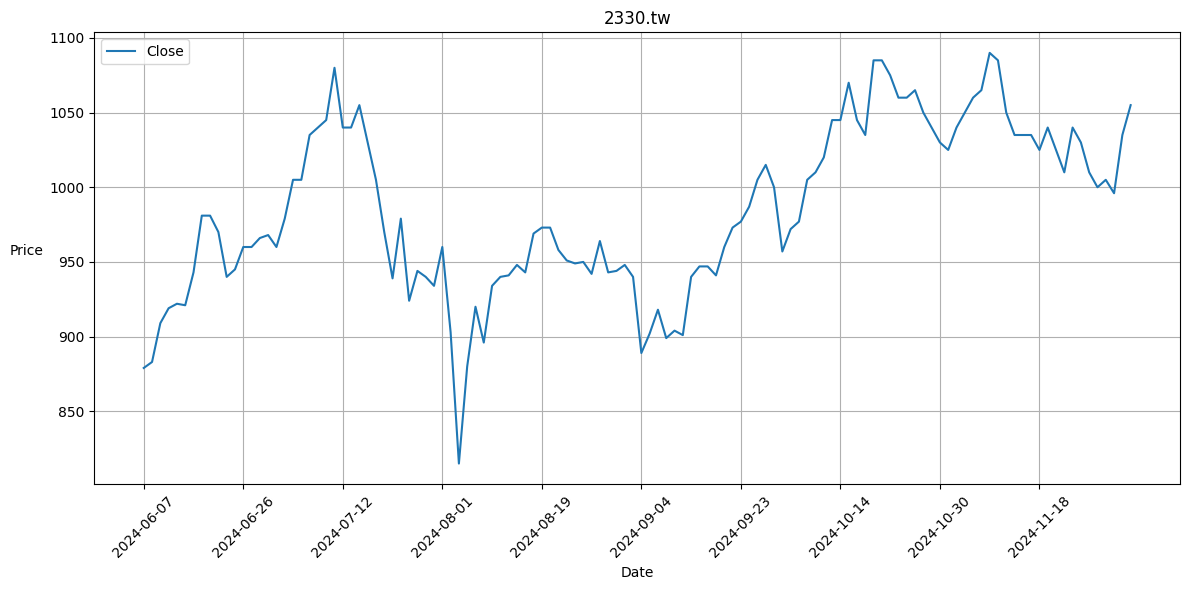

In [19]:
# 畫布尺寸大小設定
plt.figure(figsize=(12, 6))

# 設定要繪製的資料欄位
plt.plot(new_df['Close'], label='Close')

# 設定 x 軸的時間
num = 10
date = new_df["Date"].dt.strftime('%Y-%m-%d')
plt.xticks(date[::len(date)//num].index,
           date[::len(date)//num], rotation = 45)

# 設定圖表的標題，x 軸和 y 軸的標籤
plt.title(f'{stock_id}')   # 將股票代號設為圖標
plt.xlabel('Date')         # x 軸標籤
plt.ylabel('Price', rotation=0, ha='right')  # y 軸標籤
plt.legend(loc='upper left') # 在左上角顯示圖例
plt.grid(True) # 在圖上顯示網格
plt.tight_layout()

# 顯示圖表
plt.show()

### 1️⃣4️⃣ 加入成交量

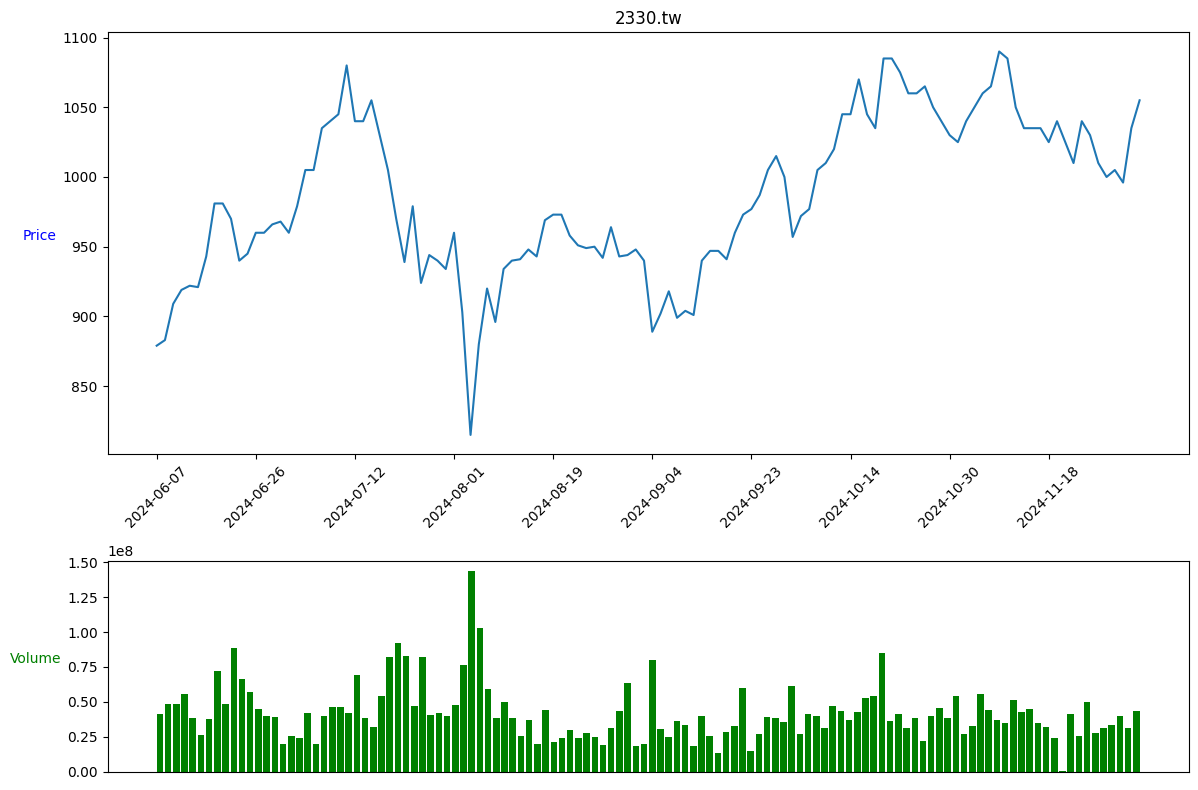

In [20]:
# 創建兩張子圖
fig, (ax1, ax2) = plt.subplots(2, 1,
                figsize=(12, 8),
                gridspec_kw={'height_ratios': [2, 1]})

# 設定 x 軸時間
num = 10
date = new_df["Date"].dt.strftime('%Y-%m-%d')

# 繪製收盤價
ax1.plot(new_df['Close'], label='Close')
ax1.set_title(f'{stock_id}')
ax1.set_ylabel('Price', color='blue', rotation=0, ha='right')
ax1.set_xticks(date[::len(date)//num].index)
ax1.set_xticklabels(date[::len(date)//num], rotation=45)

# 繪製交易量
ax2.bar(new_df.index, new_df['Volume'],  color='green')
ax2.set_ylabel('Volume', color='green', rotation=0, ha='right')
ax2.set_xticks([]) # 不顯示日期標籤
# 若要顯示圖表標籤可以使用以下程式碼
# ax2.set_xticks(date[::len(date)//num].index)
# ax2.set_xticklabels(date[::len(date)//num], rotation=45)

# 讓子圖填充、對齊
plt.tight_layout()

# 顯示圖表
plt.show()


### 1️⃣5️⃣ 加入技術指標

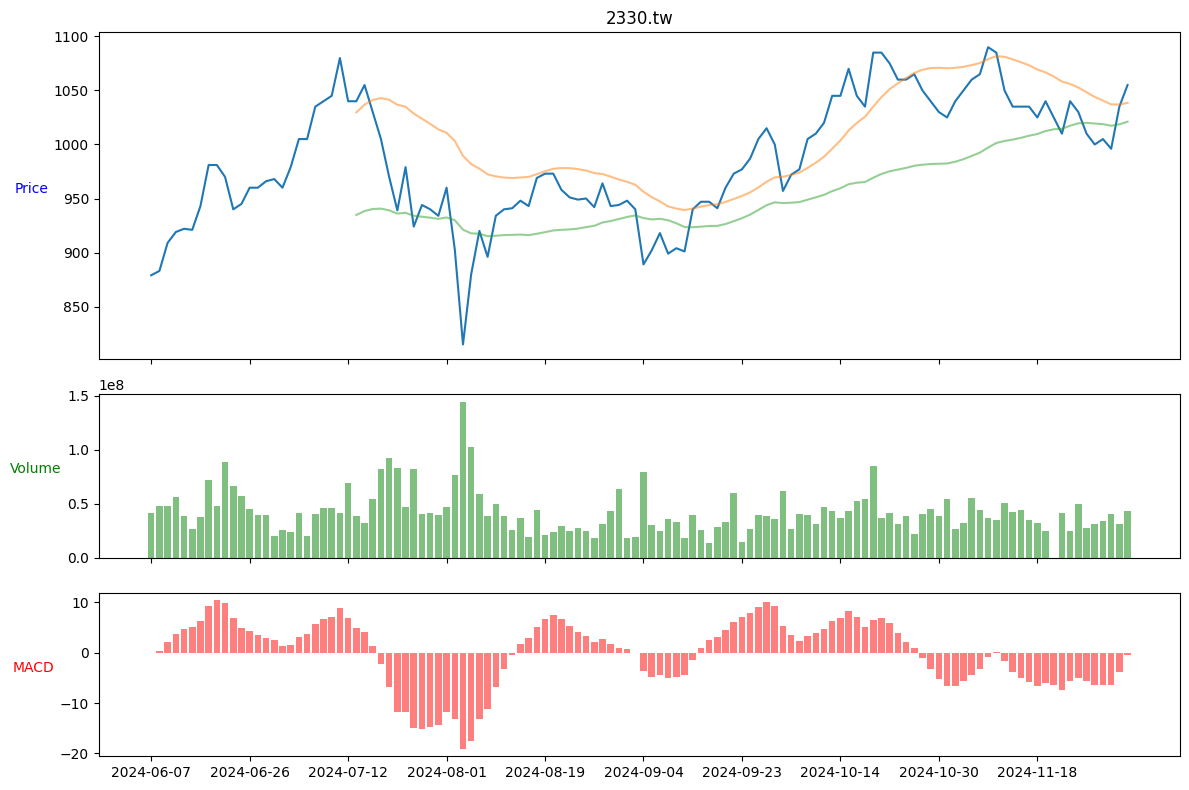

In [21]:
# 創建三個子圖
fig, (ax1, ax2, ax3) = plt.subplots(3, 1,
                    figsize=(12, 8),
                    gridspec_kw={'height_ratios': [2, 1, 1]},
                    sharex=True)

# 設定 x 軸時間
num = 10
date = new_df["Date"].dt.strftime('%Y-%m-%d')

# 繪製收盤價
ax1.plot(new_df['Close'], label='Close')
# 加入布林通道
ax1.plot(new_df['Upper_Band'], alpha=0.5) # alpha 設定透明度
ax1.plot(new_df['Lower_Band'], alpha=0.5)
ax1.set_title(f'{stock_id}')
ax1.set_ylabel('Price', color='blue', rotation=0, ha='right')
ax1.set_xticks(date[::len(date)//num].index)
ax1.set_xticklabels(date[::len(date)//num])

# 繪製交易量
ax2.bar(new_df.index, new_df['Volume'], alpha=0.5, color='green')
ax2.set_ylabel('Volume', color='green', rotation=0, ha='right')

# 繪製技術指標
ax3.bar(new_df.index, new_df['MACD_Histogram'], alpha=0.5, color='red')
ax3.set_ylabel('MACD', color='red', rotation=0, ha='right')

# 調整子圖間的距離
plt.tight_layout()

# 顯示圖表
plt.show()

### 繪製 K 線圖：mplfinance

### 1️⃣6️⃣ 匯入技術分析繪圖套件

In [23]:
!pip install mplfinance
import mplfinance as mpf

### 1️⃣7️⃣ 選擇資料時間

In [24]:
kplot_df = new_df.set_index('Date')
kplot_df = kplot_df['2024-02-01':'2024-07-29']
kplot_df.tail()

,index,Open,High,Low,Close,Adj Close,Volume,8d_MA,13d_MA,EMA_12,...,down,avg_up,avg_down,RSI,Upper_Band,Lower_Band,OBV,OBV_SMA,OBV_EMA,Month
Date,,,,,,,,,,,,,,,,,,,,,
2024-07-19,29,988.0,995.0,970.0,970.0,965.693542,92507621,1033.125,1025.307692,1014.058067,...,35.0,6.884461,13.184877,34.303380,1041.327199,939.055966,-92507621,2231332.30,-9.471546e+06,2024-07
2024-07-22,30,964.0,965.0,938.0,939.0,934.831177,83062356,1019.875,1022.230769,1002.510672,...,31.0,5.966533,15.560227,27.716820,1036.745037,936.054189,-83062356,1397814.20,-1.648019e+07,2024-07
2024-07-23,31,963.0,979.0,956.0,979.0,974.653564,47213266,1007.250,1020.230769,998.893646,...,0.0,10.504329,13.485530,43.786539,1034.930919,936.772069,47213266,890055.90,-1.041415e+07,2024-07
2024-07-26,32,915.0,930.0,915.0,924.0,919.897766,82081735,992.750,1014.000000,987.371546,...,55.0,9.103752,19.020792,32.369419,1028.527408,934.012395,-82081735,-5462389.15,-1.723963e+07,2024-07
2024-07-29,33,942.0,948.0,936.0,944.0,939.808960,40809258,980.750,1007.000000,980.699001,...,0.0,10.556585,16.484687,39.038788,1023.867073,933.151264,40809258,-3421926.25,-1.171117e+07,2024-07


### 1️⃣8️⃣ 用 mplfinance 繪製 K 線圖

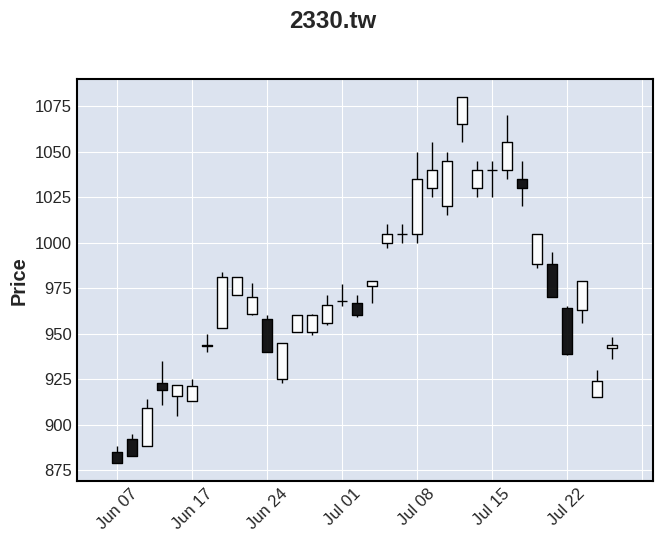

In [25]:
mpf.plot(kplot_df, type='candle', title=f'{stock_id}')

### 1️⃣9️⃣ 加入繪圖設定

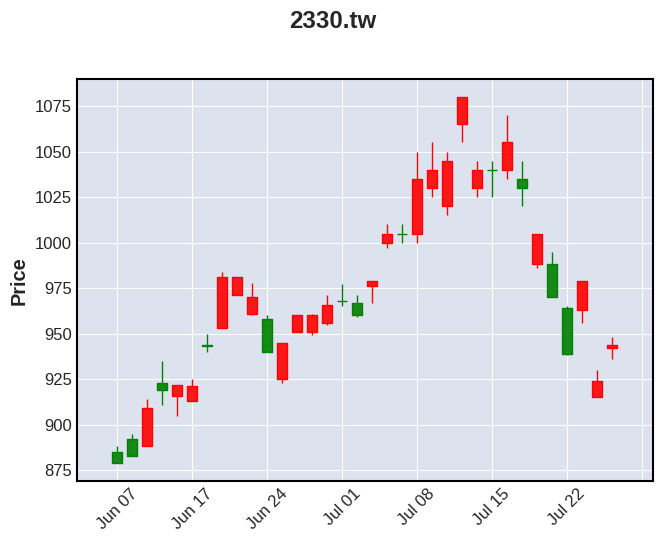

In [26]:
# 設置繪圖風格
my_color = mpf.make_marketcolors(up='r', down='g', inherit=True)
my_style = mpf.make_mpf_style(base_mpf_style='default',
                marketcolors=my_color)
# 使用 mplfinance 繪製 K 線圖
mpf.plot(kplot_df, type='candle',
    style=my_style, title=f'{stock_id}')

### 2️⃣0️⃣ 加入子圖

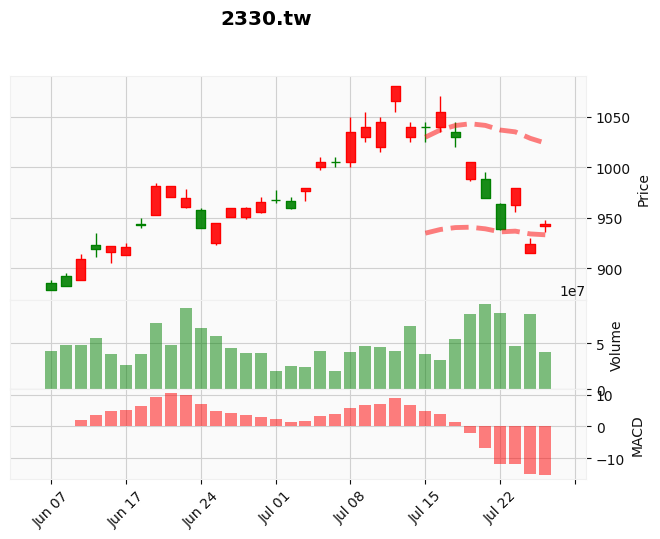

In [27]:
# 設置繪圖風格
my_color = mpf.make_marketcolors(up='r', down='g', inherit=True)
my_style = mpf.make_mpf_style(base_mpf_style='yahoo',
                marketcolors=my_color)

# 交易量和技術指標子圖
ap = [
    # 上軌線
    mpf.make_addplot(kplot_df['Upper_Band'], color='red',
                      alpha=0.5, linestyle='--'),
    # 下軌線
    mpf.make_addplot(kplot_df['Lower_Band'], color='red',
                     alpha=0.5, linestyle='--'),
    # 成交量
    mpf.make_addplot(kplot_df['Volume'], panel=1, type='bar',
                     color='g', alpha=0.5, ylabel='Volume'),
    # MACD
    mpf.make_addplot(kplot_df['MACD_Histogram'], panel=2, type='bar',
                     color='r', alpha=0.5, ylabel='MACD')
]

# 使用 mplfinance 繪製 K 線圖
mpf.plot(kplot_df, type='candle', addplot=ap,
          style=my_style, title=f'{stock_id}')

## 4-3 plotly 互動式圖表

### 2️⃣1️⃣ 檢視資料

In [28]:
bk_df = new_df
bk_df.index = bk_df["Date"].dt.strftime('%Y-%m-%d')
bk_df.tail()

,index,Date,Open,High,Low,Close,Adj Close,Volume,8d_MA,13d_MA,...,down,avg_up,avg_down,RSI,Upper_Band,Lower_Band,OBV,OBV_SMA,OBV_EMA,Month
Date,,,,,,,,,,,,,,,,,,,,,
2024-11-27,115,2024-11-27,1010.0,1020.0,1000.0,1000.0,1000.0,31276090,1022.500,1032.307692,...,10.0,4.863061,9.339023,34.241883,1043.992804,1019.358234,-31276090,-7863181.85,-1.198285e+07,2024-11
2024-11-28,116,2024-11-28,1005.0,1005.0,992.0,1005.0,1005.0,33689956,1020.000,1026.153846,...,0.0,4.881319,8.093820,37.620555,1040.599835,1018.799275,33689956,-4268584.85,-7.633061e+06,2024-11
2024-11-29,117,2024-11-29,995.0,1010.0,994.0,996.0,996.0,40094983,1014.500,1022.000000,...,9.0,4.230477,8.214644,33.993056,1037.089336,1017.317247,-40094983,-3549321.25,-1.072467e+07,2024-11
2024-12-02,118,2024-12-02,1020.0,1040.0,1015.0,1035.0,1035.0,31168404,1015.750,1022.000000,...,0.0,8.866413,7.119358,55.464407,1036.951829,1018.609822,31168404,-3328299.95,-6.734855e+06,2024-12
2024-12-03,119,2024-12-03,1060.0,1065.0,1055.0,1055.0,1055.0,43414538,1021.375,1023.538462,...,0.0,10.350892,6.170110,62.652929,1038.492590,1021.101531,43414538,-2776854.15,-1.958723e+06,2024-12


### 2️⃣2️⃣ 匯入 plotly 套件

In [30]:
import plotly.graph_objects as go

### 2️⃣3️⃣ 繪製互動式 K 線圖

In [31]:
# 創建 K 線圖
fig = go.Figure(data=[go.Candlestick(x=bk_df.index,
            open=bk_df['Open'],
            high=bk_df['High'],
            low=bk_df['Low'],
            close=bk_df['Close'],
            increasing_line_color='red',
            decreasing_line_color='green')])

# 調整寬高
fig.update_layout(
    height=800,
    width=1200
)

# 顯示圖表
fig.show()

### 2️⃣4️⃣ 移除非交易日空值
解決繪圖不連續問題

In [32]:
# 創建 K 線圖
fig = go.Figure(data=[go.Candlestick(x=bk_df.index,
            open=bk_df['Open'],
            high=bk_df['High'],
            low=bk_df['Low'],
            close=bk_df['Close'],
            increasing_line_color='red',
            decreasing_line_color='green')])

# 調整寬高
fig.update_layout(
    height=800,
    width=1200
)

# 移除非交易日空值
# 生成該日期範圍內的所有日期
all_dates = pd.date_range(start=bk_df.index.min(),
              end=bk_df.index.max())
# 找出不在資料中的日期
breaks = all_dates[~all_dates.isin(bk_df.index)]
dt_breaks = breaks.tolist() # 轉換成列表
fig.update_xaxes(rangebreaks=[{'values': dt_breaks}])

# 顯示圖表
fig.show()

<ipython-input-32-11ede7c86549>:21: FutureWarning:

The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.



### 2️⃣5️⃣ 加入懸停十字軸

In [33]:
# 創建 K 線圖
fig = go.Figure(data=[go.Candlestick(x=bk_df.index,
            open=bk_df['Open'],
            high=bk_df['High'],
            low=bk_df['Low'],
            close=bk_df['Close'],
            increasing_line_color='red',
            decreasing_line_color='green')])


# 圖表更新-加入懸停十字軸
fig.update_xaxes(showspikes=True, spikecolor="gray",
                 spikemode="across")
fig.update_yaxes(showspikes=True, spikecolor="gray",
                 spikemode="across")
fig.update_layout(
    height=800,
    width=1200
)


# 移除非交易日空值
all_dates = pd.date_range(start=bk_df.index.min(), end=bk_df.index.max()) # 生成該日期範圍內的所有日期
breaks = all_dates[~all_dates.isin(bk_df.index)] # 找出不在資料中的日期
dt_breaks = breaks.tolist() # 轉換成列表
fig.update_xaxes(rangebreaks=[{'values': dt_breaks}])

fig.show()

<ipython-input-33-28d88b8e0393>:24: FutureWarning:

The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.



### 2️⃣6️⃣ 加入技術指標

In [34]:
# 創建 K 線圖
fig = go.Figure(data=[go.Candlestick(x=bk_df.index,
            open=bk_df['Open'],
            high=bk_df['High'],
            low=bk_df['Low'],
            close=bk_df['Close'],
            increasing_line_color='red', decreasing_line_color='green',
            name = "K 線")])


# 布林通道
fig.add_trace(go.Scatter(
    x=bk_df.index, y=bk_df['Upper_Band'],mode='lines',
    line={'color': 'green','dash': 'dash'},name = "上軌線"))
fig.add_trace(go.Scatter(
    x=bk_df.index, y=bk_df['Lower_Band'], mode='lines',
    line={'color': 'green', 'dash': 'dash'},name = "下軌線"))

# 交易量
fig.add_trace(go.Bar(
    x=bk_df.index, y=bk_df['Volume'], marker={'color': 'green'},
      yaxis='y2', name = "交易量"))

# MACD
fig.add_trace(go.Bar(
    x=bk_df.index, y=bk_df['MACD_Histogram'], marker={'color': 'red'},
      yaxis='y3', name = "MACD"))

# 加入懸停十字軸
fig.update_xaxes(showspikes=True, spikecolor="gray",
                 spikemode="toaxis")
fig.update_yaxes(showspikes=True, spikecolor="gray",
                 spikemode="across")

# 更新畫布大小並增加範圍選擇
fig.update_layout(
    height=800,
    yaxis={'domain': [0.35, 1]},
    yaxis2={'domain': [0.15, 0.3]},
    yaxis3={'domain': [0, 0.15]},
    title=f"{stock_id}",
    xaxis={
        # 範圍選擇格
        'rangeselector': {
            'buttons': [
                {'count': 1, 'label': '1M',
                  'step': 'month', 'stepmode': 'backward'},
                {'count': 6, 'label': '6M',
                  'step': 'month', 'stepmode': 'backward'},
                {'count': 1, 'label': '1Y',
                  'step': 'year', 'stepmode': 'backward'},
                {'step': 'all'}
            ]
        },
        # 範圍滑動條
        'rangeslider': {
            'visible': True,
            # 滑動條的高度 (設置 0.01 就會變單純的 bar)
            'thickness': 0.01,
            'bgcolor': "#E4E4E4"  # 背景色
        },
        'type': 'date'
    }
)


# 移除非交易日空值
all_dates = pd.date_range(start=bk_df.index.min(), end=bk_df.index.max()) # 生成該日期範圍內的所有日期
breaks = all_dates[~all_dates.isin(bk_df.index)] # 找出不在資料中的日期
dt_breaks = breaks.tolist() # 轉換成列表
fig.update_xaxes(rangebreaks=[{'values': dt_breaks}])

fig.show()

<ipython-input-34-c4952c4d4546>:69: FutureWarning:

The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.



### 2️⃣7️⃣ 寫成函式

In [35]:
# 下載資料並讓 AI 計算指標
def download_stock_data(stock_id, start=None,
                        end=None, indicator='MACD'):
    stock_id = f"{stock_id}.tw"
    if not end:
        end = dt.date.today()
    if not start:
        start = end - dt.timedelta(days=365)
    # 從 yf 下載資料
    df = yf.download(stock_id, start=start, end=end).reset_index()

    # AI 計算技術指標
    code_str = ai_helper(df, f"計算{indicator}")
    print(code_str)

    # 將 exec 生成的 calculate 設為局部變數
    local_vars = {}
    exec(code_str, globals(), local_vars)
    calculate = local_vars['calculate']

    df = calculate(df)

    # 資料處理
    bk_df = df.reset_index()
    bk_df.index = bk_df["Date"].dt.strftime('%Y-%m-%d')

    return bk_df

# 繪製圖表函式
def create_stock_figure(stock_id, bk_df):

    # 創建 K 線圖
    fig = go.Figure(data=[go.Candlestick(x=bk_df.index,
                        open=bk_df['Open'],
                        high=bk_df['High'],
                        low=bk_df['Low'],
                        close=bk_df['Close'],
                        increasing_line_color='red',
                        decreasing_line_color='green',
                        name = "K 線")])

    # 交易量
    fig.add_trace(go.Bar(x=bk_df.index, y=bk_df['Volume'],
                         marker={'color': 'green'}, yaxis='y2',
                           name = "交易量"))

    # 找出需要繪製的欄位
    columns = bk_df.columns
    exclude_columns = ['index','Date', 'Open', 'High',
                        'Low', 'Close', 'Adj Close', 'Volume']
    remain_columns = [col for col in columns if
                       col not in exclude_columns]
    min_close = bk_df['Close'].min() - bk_df['Close'].std()
    max_close = bk_df['Close'].max() + bk_df['Close'].std()
    # 繪製技術指標
    for i in remain_columns:
      if min_close <= bk_df[i].mean() <= max_close:
        fig.add_trace(go.Scatter(x=bk_df.index, y=bk_df[i],
                                  mode='lines', name=i))
      else:
        fig.add_trace(go.Scatter(x=bk_df.index, y=bk_df[i],
                                  mode='lines', yaxis='y3', name=i))

    # 加入懸停十字軸
    fig.update_xaxes(showspikes=True, spikecolor="gray",
                    spikemode="toaxis")
    fig.update_yaxes(showspikes=True, spikecolor="gray",
                    spikemode="across")
    # 更新畫布大小並增加範圍選擇
    fig.update_layout(
        height=800,
        width=1200,
        yaxis={'domain': [0.35, 1]},
        yaxis2={'domain': [0.15, 0.3]},
        # 若要重疊 y1 和 y3, 可以改成
        # yaxis3=dict(overlaying='y', side='right')
        yaxis3={'domain': [0, 0.15]},
        title=f"{stock_id}",
        xaxis={
            # 範圍選擇格
            'rangeselector': {
                'buttons': [
                    {'count': 1, 'label': '1M',
                      'step': 'month', 'stepmode': 'backward'},
                    {'count': 6, 'label': '6M',
                      'step': 'month', 'stepmode': 'backward'},
                    {'count': 1, 'label': '1Y',
                      'step': 'year', 'stepmode': 'backward'},
                    {'step': 'all'}
                ]
            },
            # 範圍滑動條
            'rangeslider': {
                'visible': True,
                'thickness': 0.01,  # 滑動條的高度
                'bgcolor': "#E4E4E4"  # 背景色
            },
            'type': 'date'
        }
    )

    # 移除非交易日空值
    # 生成該日期範圍內的所有日期
    all_dates = pd.date_range(start=bk_df.index.min(),
                               end=bk_df.index.max())
    # 找出不在資料中的日期
    breaks = all_dates[~all_dates.isin(bk_df.index)]
    dt_breaks = breaks.tolist() # 轉換成列表格式
    fig.update_xaxes(rangebreaks=[{'values': dt_breaks}])

    return fig

# 主函式
def plotly_stock(stock_id, start=None, end=None, indicator='MACD'):

    df = download_stock_data(stock_id, start, end, indicator)
    fig = create_stock_figure(stock_id,df)
    fig.show()

### 2️⃣8️⃣ 執行函式

In [36]:
plotly_stock("2317", start='2022-01-01', end= None,
             indicator='布林通道及MACD')

[*********************100%%**********************]  1 of 1 completed


def calculate(df):
    # Calculate Bollinger Bands
    df['EMA'] = df['Close'].ewm(span=20, adjust=False).mean()
    df['std_dev'] = df['Close'].rolling(window=20).std()
    df['upper_band'] = df['EMA'] + (2 * df['std_dev'])
    df['lower_band'] = df['EMA'] - (2 * df['std_dev'])

    # Calculate MACD
    df['EMA_12'] = df['Close'].ewm(span=12, adjust=False).mean()
    df['EMA_26'] = df['Close'].ewm(span=26, adjust=False).mean()
    df['MACD'] = df['EMA_12'] - df['EMA_26']
    df['signal_line'] = df['MACD'].ewm(span=9, adjust=False).mean()

    return df


<ipython-input-35-a35f8eaabc95>:107: FutureWarning:

The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.

